
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names: Fateme Tamehri, Mahdi OstadMohammadi

Student Numbers: <font size=5 color=cyan>  402111129, 402111453

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [228]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [246]:
DATA_DIR = "/Users/divar/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 5
NUM_WORKERS = 6
LR = 1e-3
NUM_EPOCHS = 20

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [37]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/divar/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [127]:
import os
import numpy as np
from PIL import Image
import glob

def load_images_and_masks(images_path, masks_path, image_size):
    images = []
    masks = []
    
    for img_path, mask_path in zip(images_path, masks_path):
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(image_size, Image.Resampling.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0
        images.append(img_array)
        
        mask = Image.open(mask_path)
        if mask.mode != 'L':
            mask = mask.convert('L')
        mask = mask.resize(image_size, Image.Resampling.NEAREST)
        mask_array = np.array(mask, dtype=np.float32) / 255.0
        masks.append(mask_array)
    
    return np.array(images), np.array(masks)

train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir = os.path.join(DATA_DIR, 'tiff/train_labels')

train_images_path = sorted(glob.glob(os.path.join(train_images_dir, '*.tif*')))
train_masks_path = sorted(glob.glob(os.path.join(train_masks_dir, '*.tif*')))

assert len(train_images_path) == len(train_masks_path), f"Mismatch: {len(train_images_path)} images vs {len(train_masks_path)} masks"

train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir = os.path.join(DATA_DIR, 'tiff/val_labels')

val_images_path = sorted(glob.glob(os.path.join(val_images_dir, '*.tif*')))
val_masks_path = sorted(glob.glob(os.path.join(val_masks_dir, '*.tif*')))

assert len(val_images_path) == len(val_masks_path), f"Mismatch: {len(val_images_path)} images vs {len(val_masks_path)} masks"

val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)

print(f"Training data: {train_images.shape} images, {train_masks.shape} masks")
print(f"Validation data: {val_images.shape} images, {val_masks.shape} masks")

Training data: (1108, 256, 256, 3) images, (1108, 256, 256) masks
Validation data: (14, 256, 256, 3) images, (14, 256, 256) masks


### Data Visualization

Display the images and their masks for several samples.

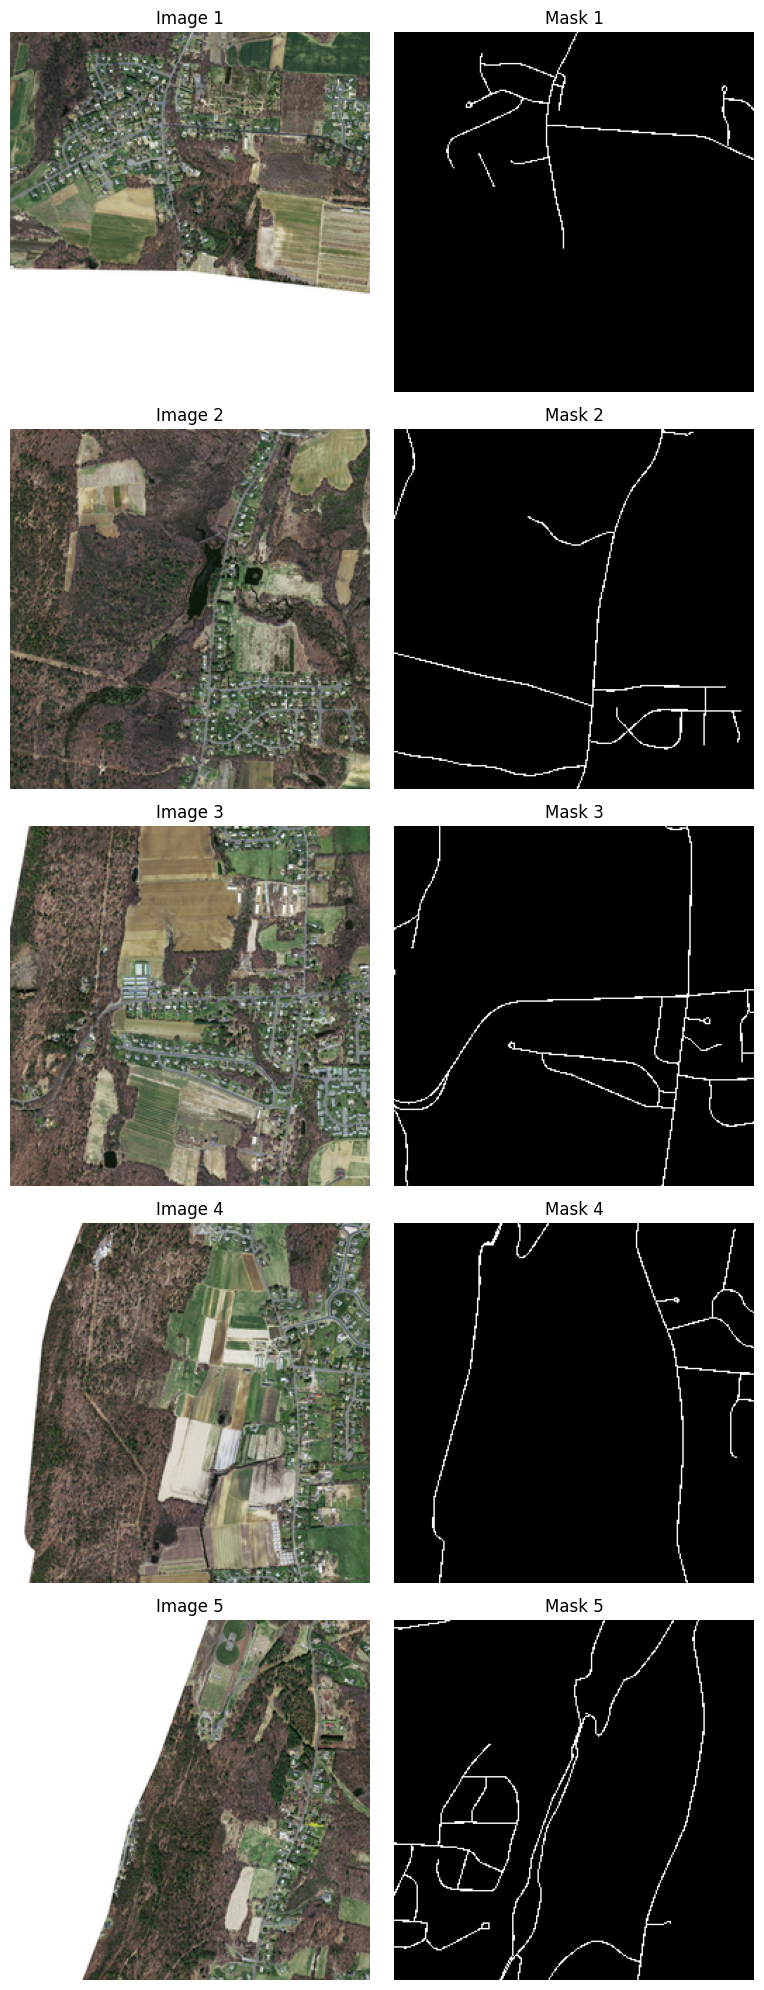

In [128]:
import matplotlib.pyplot as plt

def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (array-like): Collection of input images.
        masks (array-like): Collection of corresponding mask images.
        n (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(8, 4 * n))

    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')
        
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_masks(train_images, train_masks, n=5)

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [138]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

class RoadDataset(Dataset):
    """
    Custom Dataset class for loading road images and their corresponding masks.

    Args:
        images (array-like): List or array of input images.
        masks (array-like): List or array of corresponding masks.
        image_transform (callable, optional): Transformation to apply to the images.
        mask_transform (callable, optional): Transformation to apply to the masks.
    """
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        print(f"Dataset created with {len(images)} samples")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of workers: {NUM_WORKERS}")

Dataset created with 1108 samples
Dataset created with 14 samples
Train loader: 277 batches
Val loader: 4 batches
Batch size: 4
Number of workers: 6


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [216]:
import torch.nn as nn

class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
      return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [217]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
      super().__init__()
      self.upconv = nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2)
      )

    def forward(self, x):
      return self.upconv(x)


### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [218]:
      
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(in_channel, filter[0])
        self.conv2 = ConvBlock(filter[0], filter[1])
        self.conv3 = ConvBlock(filter[1], filter[2])
        self.conv4 = ConvBlock(filter[2], filter[3])

        self.bottleneck = ConvBlock(filter[3], filter[3] * 2)

        self.upconv4 = UpConvBlock(filter[3] * 2, filter[3])
        self.d_conv4 = ConvBlock(filter[3] * 2, filter[3])

        self.upconv3 = UpConvBlock(filter[3], filter[2])
        self.d_conv3 = ConvBlock(filter[2] * 2, filter[2])

        self.upconv2 = UpConvBlock(filter[2], filter[1])
        self.d_conv2 = ConvBlock(filter[1] * 2, filter[1])

        self.upconv1 = UpConvBlock(filter[1], filter[0])
        self.d_conv1 = ConvBlock(filter[0] * 2, filter[0])

        self.out_conv = nn.Conv2d(filter[0], out_channel, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        p1 = self.pool(x1)

        x2 = self.conv2(p1)
        p2 = self.pool(x2)

        x3 = self.conv3(p2)
        p3 = self.pool(x3)

        x4 = self.conv4(p3)
        p4 = self.pool(x4)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b)
        c4 = torch.cat([u4, x4], dim=1)
        d4 = self.d_conv4(c4)

        u3 = self.upconv3(d4)
        c3 = torch.cat([u3, x3], dim=1)
        d3 = self.d_conv3(c3)

        u2 = self.upconv2(d3)
        c2 = torch.cat([u2, x2], dim=1)
        d2 = self.d_conv2(c2)

        u1 = self.upconv1(d2)
        c1 = torch.cat([u1, x1], dim=1)
        d1 = self.d_conv1(c1)

        out = self.out_conv(d1)
        out = self.sigmoid(out)
        
        return out

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [219]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
      super().__init__()

      self.w_g = nn.Sequential(
          nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
          nn.BatchNorm2d(f_int)
      )

      self.w_x = nn.Sequential(
          nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
          nn.BatchNorm2d(f_int)
      )

      self.psi = nn.Sequential(
          nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
          nn.BatchNorm2d(1),
          nn.Sigmoid()
      )

      self.act = nn.ReLU(inplace=True)


    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.act(g1 + x1)
        psi = self.psi(psi)
        return x * psi

Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [233]:
class AttentionUNet(UNet):
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter)
        
        self.attention1 = AttentionBlock(f_g=filter[3], f_l=filter[3], f_int=filter[3]//2)
        self.attention2 = AttentionBlock(f_g=filter[2], f_l=filter[2], f_int=filter[2]//2)
        self.attention3 = AttentionBlock(f_g=filter[1], f_l=filter[1], f_int=filter[1]//2)

    def forward(self, x):
        x1 = self.conv1(x)
        p1 = self.pool(x1)

        x2 = self.conv2(p1)
        p2 = self.pool(x2)

        x3 = self.conv3(p2)
        p3 = self.pool(x3)

        x4 = self.conv4(p3)
        p4 = self.pool(x4)

        b = self.bottleneck(p4)

        u4 = self.upconv4(b)
        x4_att = self.attention1(u4, x4)
        c4 = torch.cat([u4, x4_att], dim=1)
        d4 = self.d_conv4(c4)

        u3 = self.upconv3(d4)
        x3_att = self.attention2(u3, x3)
        c3 = torch.cat([u3, x3_att], dim=1)
        d3 = self.d_conv3(c3)

        u2 = self.upconv2(d3)
        x2_att = self.attention3(u2, x2)
        c2 = torch.cat([u2, x2_att], dim=1)
        d2 = self.d_conv2(c2)

        u1 = self.upconv1(d2)
        c1 = torch.cat([u1, x1], dim=1)
        d1 = self.d_conv1(c1)

        out = self.out_conv(d1)
        out = self.sigmoid(out)
        
        return out

# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [240]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.final_relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return self.final_relu(out)

Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [242]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        f = filter_sizes
        
        self.conv1 = ResidualConvBlock(in_channel, f[0])
        self.conv2 = ResidualConvBlock(f[0], f[1])
        self.conv3 = ResidualConvBlock(f[1], f[2])
        self.conv4 = ResidualConvBlock(f[2], f[3])

        self.bottleneck = ResidualConvBlock(f[3], f[3] * 2)

        self.d_conv4 = ResidualConvBlock(f[3] * 2, f[3])
        self.d_conv3 = ResidualConvBlock(f[2] * 2, f[2])
        self.d_conv2 = ResidualConvBlock(f[1] * 2, f[1])
        self.d_conv1 = ResidualConvBlock(f[0] * 2, f[0])

    def forward(self, x):

        return super().forward(x)

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [221]:

### DICE LOSS
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)
        intersection = (pred * real).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + real.sum() + self.smooth)
        return 1 - dice_coeff


### Iou Loss
class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)
        
        intersection = (pred * real).sum()
        
        total = (pred + real).sum()
        union = total - intersection 
        
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        
        return 1 - iou_coeff

### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [222]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        data_loader (DataLoader): DataLoader providing training batches.
        scheduler (optional): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').

    Returns:
        float: Average loss over the epoch.
    """

    total_loss = 0.0
    model.train()
    for i, (img, mask) in enumerate(tqdm(data_loader)):
        img = img.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()

        pred = model(img)
        _, _, _, loss = criterion(pred, mask)
        loss.backward()

        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

Design a function for evaluation after each training phase.

In [223]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    """
    Enhanced evaluation with Precision, Recall, F1-Score
    """
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            mask = mask.to(device)

            pred = model(img)
            dice_loss, iou_loss, _, overall_loss = criterion(pred, mask)

            pred_flat = pred.view(-1)
            mask_flat = mask.view(-1)
            
            pred_binary = (pred_flat > 0.5).float()
            
            TP = (pred_binary * mask_flat).sum()
            FP = (pred_binary * (1 - mask_flat)).sum()
            FN = ((1 - pred_binary) * mask_flat).sum()
            

            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()
            dice_score += 1 - dice_loss.item()

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score

# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [ ]:
import torch.multiprocessing as mp

mp.set_start_method('fork', force=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

unet = UNet().to(device) 
criterion = OverallLoss()
optimizer = Adam(unet.parameters(), lr=LR)

print("Starting UNet training...")
print(f"Using {NUM_WORKERS} workers")

print(f"Model parameters: {sum(p.numel() for p in unet.parameters())}")

best_loss = 100.0
best_Iou = 0.0
best_dice = 0.0
for i in range(NUM_EPOCHS):
    print("In training")
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader, device=device)
    print("Done with training")
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader, device=device)

    best_dice = max(dice_score, best_dice)
    best_Iou = max(iou_score, best_Iou)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")
    if best_loss < 1 and best_Iou > 0.5 and best_dice > 0.6:
        break


print(f"UNet Training completed! Best validation loss: {best_loss:.4f}")
print(f"Best Iou Score: {best_Iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")


Training on device: cpu
Starting UNet training...
Using 6 workers
Model parameters: 31037633
In training


100%|██████████| 277/277 [15:28<00:00,  3.35s/it]


Done with training


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Iteration 1/20: Train Loss: 1.78 | Val Loss: 1.33 | Iou Score: 0.34 | Dice Score: 0.51
In training


100%|██████████| 277/277 [15:39<00:00,  3.39s/it]


Done with training


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Iteration 2/20: Train Loss: 1.26 | Val Loss: 1.08 | Iou Score: 0.46 | Dice Score: 0.63
In training


100%|██████████| 277/277 [15:49<00:00,  3.43s/it]


Done with training


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Iteration 3/20: Train Loss: 1.15 | Val Loss: 1.06 | Iou Score: 0.47 | Dice Score: 0.64
In training


100%|██████████| 277/277 [15:37<00:00,  3.38s/it]


Done with training


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Iteration 4/20: Train Loss: 1.10 | Val Loss: 1.00 | Iou Score: 0.50 | Dice Score: 0.67
In training


100%|██████████| 277/277 [14:58<00:00,  3.24s/it]


Done with training


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

Iteration 5/20: Train Loss: 1.07 | Val Loss: 0.97 | Iou Score: 0.51 | Dice Score: 0.68
UNet Training completed! Best validation loss: 0.9650
Best Iou Score: 0.5112
Best Dice Score: 0.6760


Now do the same for Attention UNet and Reidual Attention UNet.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
optimizer = Adam(attention_unet.parameters(), lr=LR)
import random

best_loss = 100.0
best_Iou = 0.0
best_dice = 0.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader, device=device)

    best_dice = max(dice_score, best_dice)
    best_Iou = max(iou_score, best_Iou)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")
    
    if best_loss < 0.9 and best_Iou > 0.6 and best_dice > 0.65:
        break


print(f"Attention UNet Training completed! Best validation loss: {best_loss:.4f}")
print(f"Best Iou Score: {best_Iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")

100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Iteration 1/20: Train Loss: 1.63 | Val Loss: 1.24 | Iou Score: 0.38 | Dice Score: 0.55


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Iteration 2/20: Train Loss: 1.19 | Val Loss: 1.05 | Iou Score: 0.48 | Dice Score: 0.65


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Iteration 3/20: Train Loss: 1.12 | Val Loss: 1.00 | Iou Score: 0.50 | Dice Score: 0.67


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Iteration 4/20: Train Loss: 1.08 | Val Loss: 0.99 | Iou Score: 0.53 | Dice Score: 0.67


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Iteration 5/20: Train Loss: 1.06 | Val Loss: 0.96 | Iou Score: 0.55 | Dice Score: 0.68


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Iteration 6/20: Train Loss: 1.04 | Val Loss: 0.95 | Iou Score: 0.57 | Dice Score: 0.68


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Iteration 7/20: Train Loss: 1.03 | Val Loss: 0.92 | Iou Score: 0.59 | Dice Score: 0.70


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Iteration 8/20: Train Loss: 1.03 | Val Loss: 0.90 | Iou Score: 0.62 | Dice Score: 0.69
Attention UNet Training completed! Best validation loss: 0.8964
Best Iou Score: 0.6164
Best Dice Score: 0.7000


For Residual Attention UNet, plot the changes in train and validation loss.

In [247]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []
best_loss = 100.0
best_Iou = 0.0
best_dice = 0.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    best_dice = max(dice_score, best_dice)
    best_Iou = max(iou_score, best_Iou)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    if best_loss < 0.8 and best_Iou > 0.65 and best_dice > 0.7:
        break

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")
    
print(f"Residual Attention UNet Training completed! Best validation loss: {best_loss:.4f}")
print(f"Best Iou Score: {best_Iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")

100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Iteration 1/20: Train Loss: 1.47 | Val Loss: 1.18 | Iou Score: 0.41 | Dice Score: 0.58


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Iteration 2/20: Train Loss: 1.15 | Val Loss: 1.02 | Iou Score: 0.49 | Dice Score: 0.66


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Iteration 3/20: Train Loss: 1.09 | Val Loss: 0.99 | Iou Score: 0.51 | Dice Score: 0.67


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Iteration 4/20: Train Loss: 1.06 | Val Loss: 1.02 | Iou Score: 0.49 | Dice Score: 0.66


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Iteration 5/20: Train Loss: 1.04 | Val Loss: 0.97 | Iou Score: 0.51 | Dice Score: 0.68


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Iteration 6/20: Train Loss: 1.02 | Val Loss: 0.93 | Iou Score: 0.54 | Dice Score: 0.70


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Iteration 7/20: Train Loss: 1.01 | Val Loss: 0.90 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Iteration 8/20: Train Loss: 1.00 | Val Loss: 0.89 | Iou Score: 0.56 | Dice Score: 0.73


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Iteration 9/20: Train Loss: 0.99 | Val Loss: 0.86 | Iou Score: 0.59 | Dice Score: 0.73


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Iteration 10/20: Train Loss: 0.97 | Val Loss: 0.83 | Iou Score: 0.60 | Dice Score: 0.73


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Iteration 11/20: Train Loss: 0.97 | Val Loss: 0.82 | Iou Score: 0.62 | Dice Score: 0.73


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Iteration 12/20: Train Loss: 0.96 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.73


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Iteration 13/20: Train Loss: 0.96 | Val Loss: 0.79 | Iou Score: 0.65 | Dice Score: 0.73


  0%|          | 0/4 [00:00<?, ?it/s]python(14462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

Residual Attention UNet Training completed! Best validation loss: 0.7900
Best Iou Score: 0.6600
Best Dice Score: 0.7300


Now Visualize losses.

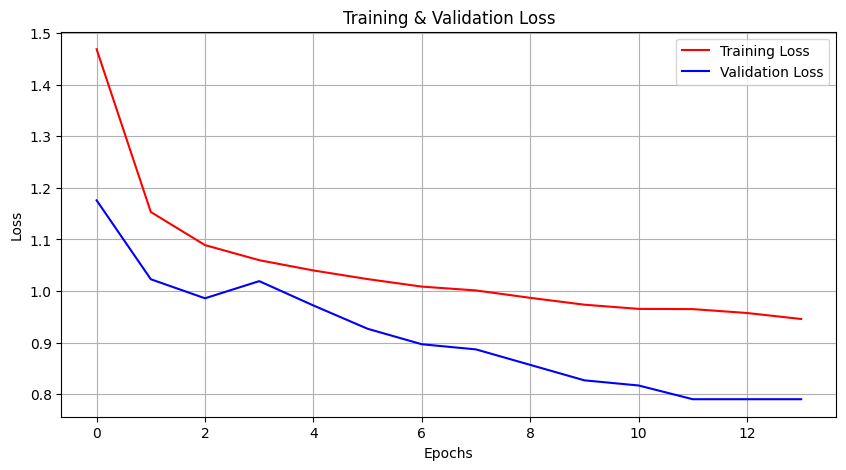

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='red', label='Training Loss')
plt.plot(val_losses, color='blue', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

python(20964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Visualizing model predictions...


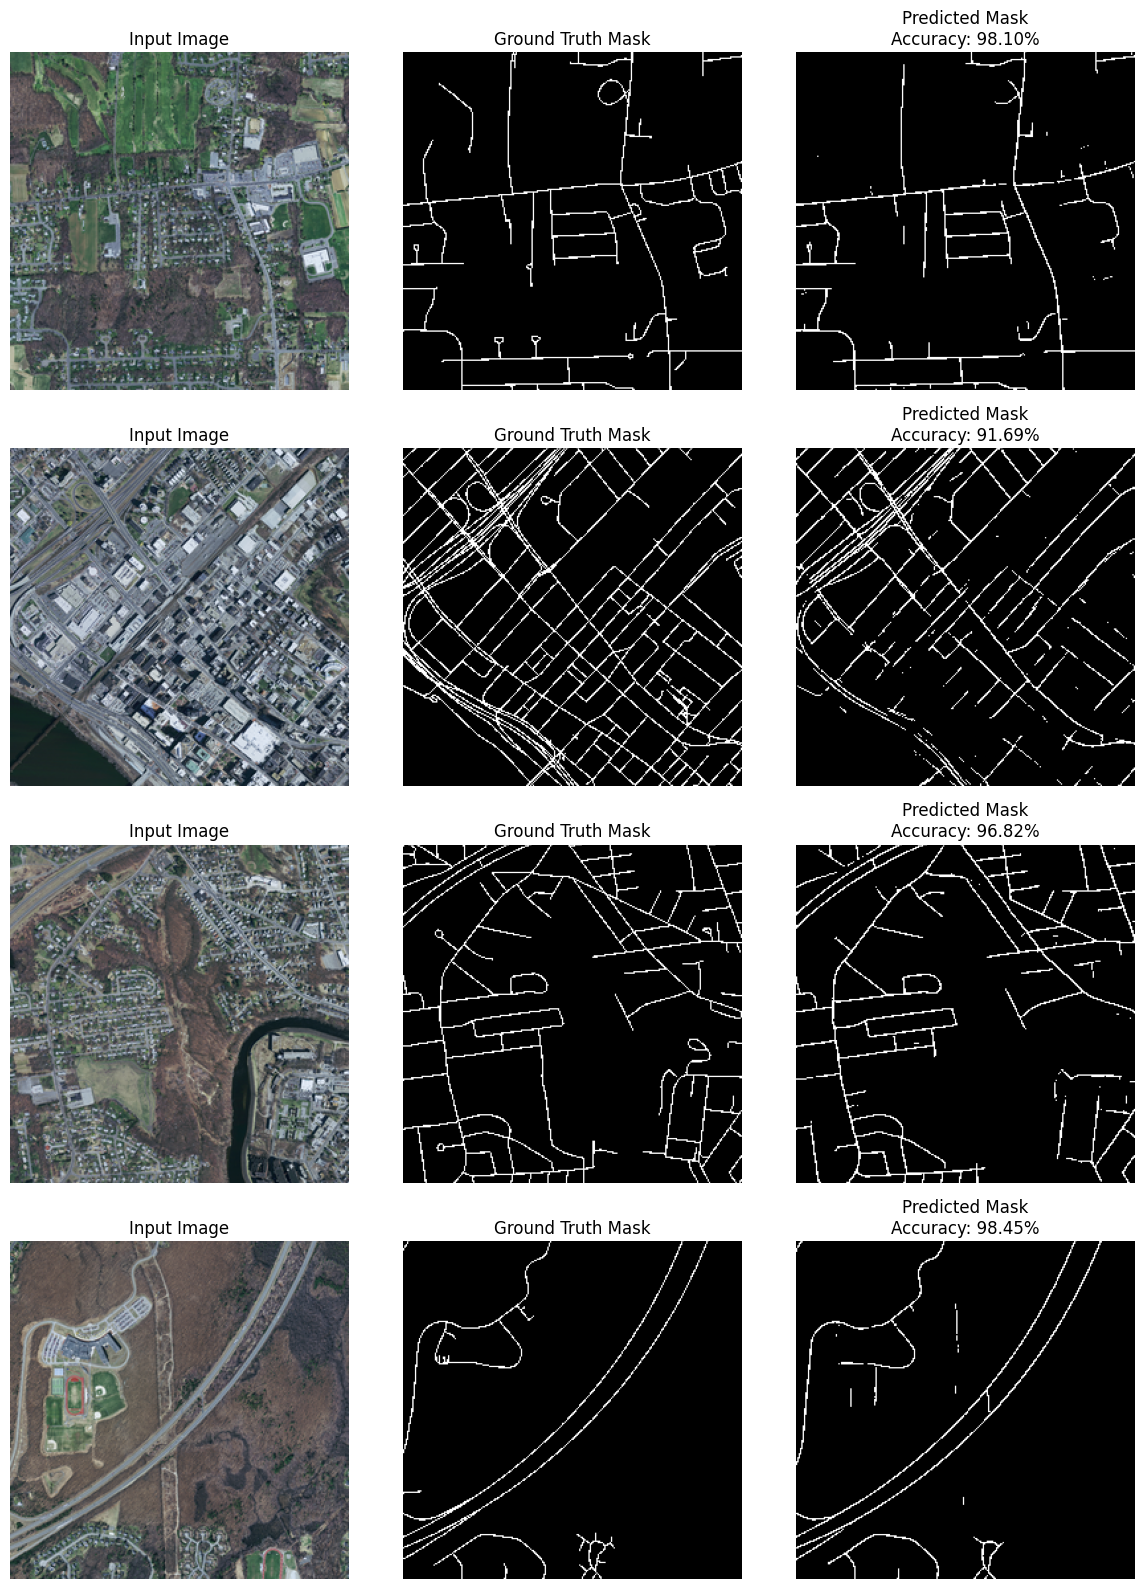

In [255]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_image_mask_prediction(images, masks, predictions, n=4):
    """
    Visualizes the input image, ground truth mask, and predicted mask,
    and displays the pixel-wise accuracy on the prediction's title.

    Args:
        images (torch.Tensor): The input images from the data loader.
        masks (torch.Tensor): The ground truth masks.
        predictions (torch.Tensor): The model's predictions.
        n (int): The number of samples to visualize.
    """
    plt.figure(figsize=(12, 4 * n))
    
    n = min(n, images.shape[0])

    for i in range(n):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        mask = masks[i].cpu().squeeze().numpy()
        pred = (predictions[i].cpu().squeeze() > 0.5).numpy()
        accuracy = (pred == mask).sum() / mask.size
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title(f"Predicted Mask\nAccuracy: {accuracy:.2%}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet(filter=[64, 128, 256, 512]).to(device)
model.load_state_dict(torch.load("best_attention_unet.pth", map_location=device))
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    predictions = model(images)
    print("Visualizing model predictions...")
    visualize_image_mask_prediction(images, masks, predictions, n=4)